## Project 3

**Mohammad Kamal Sadeghabadi Farahani**

### Description

In this project we have implemented neural populations and their connections, then we created two populations one excitatory and another inhibitory, the excitatory neurons are 80% of all neurons and the inhibitory neurons are 20% of all neurons, then we connected these two populations to each other like the figure below:

<img src="./images/pic1.png" alt="drawing" width="500"/>

We have implemented two types of connection:
1. Dense Connection: In which all neurons from pre-synaptic population are connected to all neurons of post-synaptic population
2. Random Connection: In which each neuron in post-synaptic receives input from a fixed number of neurons in pre-synaptic population

In [5]:
import torch
import random
import sys
import numpy as np

sys.path.insert(0, '../../')

from cnsproject.network.neural_populations import ELIFPopulation, LIFPopulation, AELIFPopulation
from cnsproject.network.connections import DenseConnection, RandomConnection
from cnsproject.plotting.plotting import raster_plot, plot_activity, plot_current
from cnsproject.network.monitors import Monitor

In [2]:
steps = 1000

In [3]:
def simulate_populations(steps, current_func, params_ex, params_in, C1, C2, C3, C1_params, C2_params, C3_params):
    lif_ex = LIFPopulation(**params_ex)
    lif_in = LIFPopulation(**params_in, is_inhibitory=True)
    shape_ex = params_ex['shape']
    shape_in = params_in['shape']

    synapse_in_to_ex = C1(pre=lif_in, post=lif_ex, **C1_params)
    synapse_ex_to_in = C2(pre=lif_ex, post=lif_in, **C2_params)
    synapse_ex_to_ex = C3(pre=lif_ex, post=lif_ex, **C3_params)
    
    record_time = steps * lif_ex.dt
    monitor_ex = Monitor(lif_ex, state_variables=["s", "_potential"])
    monitor_ex.set_time_steps(record_time, lif_ex.dt)
    monitor_ex.reset_state_variables()

    monitor_in = Monitor(lif_in, state_variables=["s", "_potential"])
    monitor_in.set_time_steps(record_time, lif_in.dt)
    monitor_in.reset_state_variables()

    currents = torch.zeros(steps)
    for i in range(steps):
        max_shape = max(shape_ex, shape_in)
        current = torch.ones(max_shape) * current_func(i * lif_ex.dt)
        currents[i] = current[0]
        spike_effects_in_to_ex = synapse_in_to_ex.compute(lif_in.s)
        spike_effects_ex_to_in = synapse_ex_to_in.compute(lif_ex.s)
        spike_effects_ex_to_ex = synapse_ex_to_ex.compute(lif_ex.s)
        lif_in.forward(current[:shape_in[0]], spike_effects_ex_to_in)
        lif_ex.forward(current[:shape_ex[0]], spike_effects_in_to_ex + spike_effects_ex_to_ex)
        monitor_ex.record()
        monitor_in.record()

    
    print('excitatory population parameters:', params_ex)
    print('inhibitory population parameters:', params_in)
    print('excitatory to inhibitory connection:', synapse_ex_to_in)
    print('inhibitory to excitatory connection:', synapse_in_to_ex)
    print('excitatory to excitatory connection:', synapse_ex_to_ex)
    plot_current(currents, steps, lif_ex.dt)
    spikes_ex = monitor_ex.get('s')
    spikes_in = monitor_in.get('s')
    plot_activity([spikes_ex, spikes_in], lif_in.dt)
    raster_plot([spikes_ex, spikes_in], lif_in.dt)

### Dense Connection

First we will run our simulation with Dense connections, we will create 800 excitatory neurons and 200 inhibitory neurons and connect them together as explained in the figure above with dense connections.
We will not connect excitatory population to it self with dense connection, because it is meaningless.

### Experiment 1

excitatory population parameters: {'tau': 0.1, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (800,)}
inhibitory population parameters: {'tau': 0.1, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (200,)}
excitatory to inhibitory connection: Dense Connection
inhibitory to excitatory connection: Dense Connection
excitatory to excitatory connection: Random connection with 0 presynaptic connections


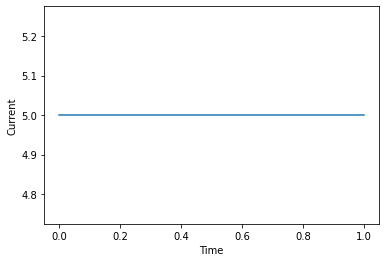

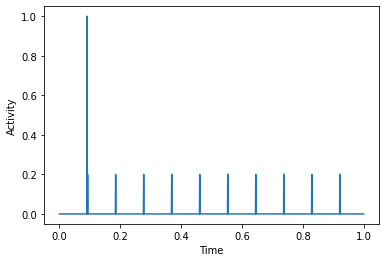

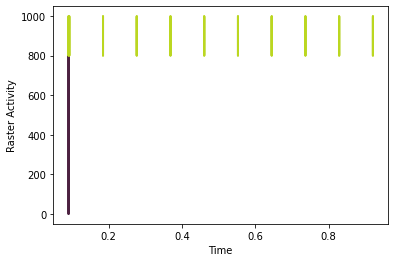

In [4]:
parameters_ex ={
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (800,)
}

parameters_in = {
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (200,)
}

current_func = lambda t: 5

simulate_populations(
    steps,current_func, parameters_ex, parameters_in,
    DenseConnection, DenseConnection, RandomConnection,
    {}, {}, { 'connection_size': 0 })

### Analysis of experiment 1
| Population | R | $u_{rest}$ | $u_{\theta}$ | $\tau$ | size
| -------  | -------| ------- | ------- | ------- | ------- |
| Excitatory | 5 | -70 | -50 | 0.1 | 800 |
| Inhibitory | 5 | -70 | -50 | 0.1 | 200 |

**Excitatory $\to$ Inhibitory**: Dense Connection  
**Inhibitory $\to$ Excitatory**: Dense Connection  
**Excitatory $\to$ Excitatory**: None  

As we can see because each population has the same parameters (except for the shape), the inhibitory neurons are inhibiting the excitatory neurons from firing, and because no population is inhibiting our inhibiory population, and all neurons are getting the same constant input current, thus all neurons in inhibitory population will spike in the periods relative to input current and population parameters.

### Random Connection
In this project we have implemented random connection as a kind of connection that connects each post-synaptic neuron to a fixed number of pre-synaptic neurons, now we will use this type of connection between our populations.

### Experiment 2

excitatory population parameters: {'tau': 0.1, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (800,)}
inhibitory population parameters: {'tau': 0.2, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (200,)}
excitatory to inhibitory connection: Random connection with 10 presynaptic connections
inhibitory to excitatory connection: Random connection with 10 presynaptic connections
excitatory to excitatory connection: Random connection with 10 presynaptic connections


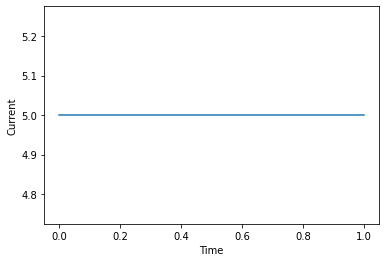

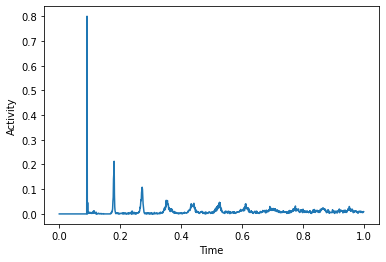

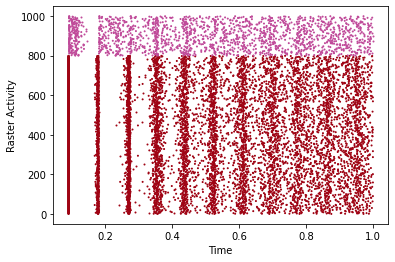

In [6]:
parameters_ex ={
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (800,)
}

parameters_in = {
    'tau': 0.2,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (200,)
}

current_func = lambda t: 5

simulate_populations(
    steps,current_func, parameters_ex, parameters_in,
    RandomConnection, RandomConnection, RandomConnection,
    { 'connection_size': 10 }, { 'connection_size': 10 }, { 'connection_size': 10 })

### Analysis of experiment 2
| Population | R | $u_{rest}$ | $u_{\theta}$ | $\tau$ | size
| -------  | -------| ------- | ------- | ------- | ------- |
| Excitatory | 5 | -70 | -50 | 0.1 | 800 |
| Inhibitory | 5 | -70 | -50 | 0.2 | 200 |

**Excitatory $\to$ Inhibitory**: Random connection with 10 presynaptic connections  
**Inhibitory $\to$ Excitatory**: Random connection with 10 presynaptic connections  
**Excitatory $\to$ Excitatory**: Random connection with 10 presynaptic connections

Because the $\tau$ parameter of excitatory population is lower than inhibitory population and the current is the same for both populations we expect that all excitatory neurons will spike earlier than inhibitory neurons, which happened in the figure above, but as soon as excitatory neurons spike, it will lead to a sudden increase in inhibitory neurons potential (because we have a random connection from excitatory to inhibitory population) so we can see that soon after swarm activity of excitatory neurons the inhibitory neurons activated and inhibited the excitatory neurons, this will lead to a more scattered activity of excitatory and inhibitory neurons as time goes on, which we can see in the figure above.

### Dense And Random Connections
We can also perform experiments that use both dense and random connections between populations.

### Experiment 3

excitatory population parameters: {'tau': 0.1, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (800,)}
inhibitory population parameters: {'tau': 0.5, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (200,)}
excitatory to inhibitory connection: Random connection with 10 presynaptic connections
inhibitory to excitatory connection: Dense Connection
excitatory to excitatory connection: Random connection with 10 presynaptic connections


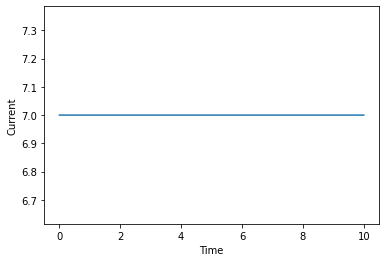

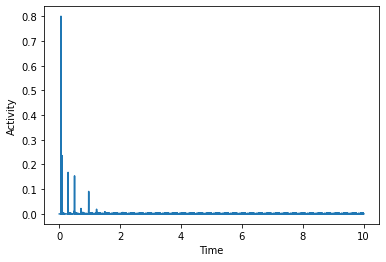

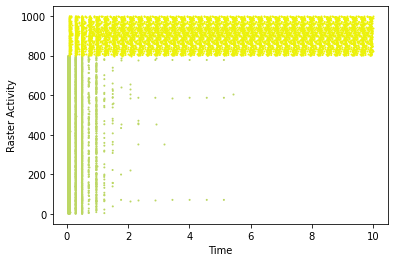

In [4]:
parameters_ex ={
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (800,)
}

parameters_in = {
    'tau': 0.5,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (200,)
}

current_func = lambda t: 7

simulate_populations(
    10 * steps, current_func, parameters_ex, parameters_in,
    DenseConnection, RandomConnection, RandomConnection,
    {}, { 'connection_size': 10 }, { 'connection_size': 10 })

### Analysis of experiment 3
| Population | R | $u_{rest}$ | $u_{\theta}$ | $\tau$ | size
| -------  | -------| ------- | ------- | ------- | ------- |
| Excitatory | 5 | -70 | -50 | 0.1 | 800 |
| Inhibitory | 5 | -70 | -50 | 0.5 | 200 |

**Excitatory $\to$ Inhibitory**: Random connection with 10 presynaptic connections  
**Inhibitory $\to$ Excitatory**: Dense Connection  
**Excitatory $\to$ Excitatory**: Random connection with 10 presynaptic connections

The dense connection from inhibitory to excitatory population will lead to strong inhibition effect on excitatory neurons, on the other hand the random connection from excitatory neurons to inhibitory neurons will lead to activation of a significant number of inhibitory neurons on swarm activation of excitatory neurons. beacuase the excitatory population has a much smaller $\tau$ parameter, the neurons in the excitatory population will activate much faster, but this activation will lead to a sudden increase in potential of many inhibitory neurons and thus it will lead to the activation of inhibitory neurons which will inhibit the activity of excitatory neurons.

### Experiment 4

excitatory population parameters: {'tau': 0.1, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (800,)}
inhibitory population parameters: {'tau': 0.2, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (200,)}
excitatory to inhibitory connection: Random connection with 10 presynaptic connections
inhibitory to excitatory connection: Random connection with 5 presynaptic connections
excitatory to excitatory connection: Random connection with 10 presynaptic connections


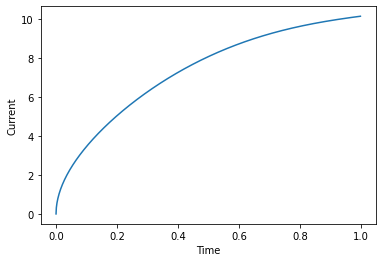

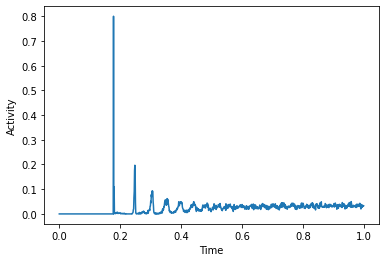

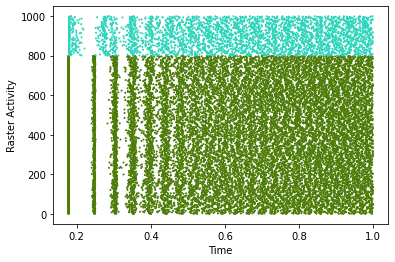

In [11]:
parameters_ex ={
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (800,)
}

parameters_in = {
    'tau': 0.2,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (200,)
}

current_func = lambda t: np.sqrt(t * 100) + np.sin(t * 3) 

simulate_populations(
    steps, current_func, parameters_ex, parameters_in,
    RandomConnection, RandomConnection, RandomConnection,
    { 'connection_size': 5 }, { 'connection_size': 10 }, { 'connection_size': 10 })

### Analysis of experiment 4
| Population | R | $u_{rest}$ | $u_{\theta}$ | $\tau$ | size
| -------  | -------| ------- | ------- | ------- | ------- |
| Excitatory | 5 | -70 | -50 | 0.1 | 800 |
| Inhibitory | 5 | -70 | -50 | 0.2 | 200 |

**Excitatory $\to$ Inhibitory**: Random connection with 10 presynaptic connections  
**Inhibitory $\to$ Excitatory**: Random connection with 5 presynaptic connections  
**Excitatory $\to$ Excitatory**: Random connection with 10 presynaptic connections

Here we have slightly the same behavior as experiment 2, but because the random connection from inhibitory to excitatory population is weaker and the $\tau$ parameter of inhibitory population is bigger than excitatory population and current is increasing thus it's harder for inhibitory population to restraint the activity of excitatory neurons.

### Experiment 5

excitatory population parameters: {'tau': 0.1, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (800,)}
inhibitory population parameters: {'tau': 0.1, 'resistance': 5, 'rest_potential': -70, 'threshold': -55, 'shape': (200,)}
excitatory to inhibitory connection: Random connection with 10 presynaptic connections
inhibitory to excitatory connection: Random connection with 5 presynaptic connections
excitatory to excitatory connection: Random connection with 20 presynaptic connections


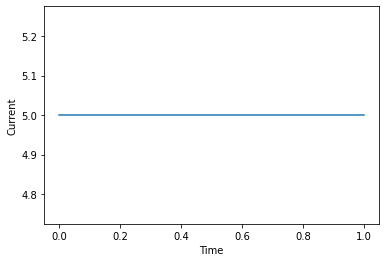

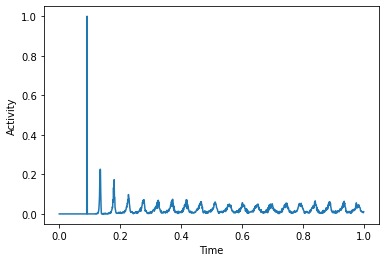

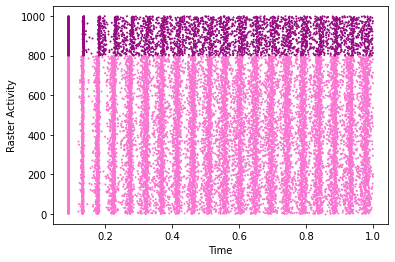

In [21]:
parameters_ex ={
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (800,)
}

parameters_in = {
    'tau': 0.1,
    'resistance': 5,
    'rest_potential': -70,
    'threshold': -55,
    'shape': (200,)
}

current_func = lambda t: 5

simulate_populations(
    steps, current_func, parameters_ex, parameters_in,
    RandomConnection, RandomConnection, RandomConnection,
    { 'connection_size': 5 }, { 'connection_size': 10 }, { 'connection_size': 20 })

### Analysis of experiment 5
| Population | R | $u_{rest}$ | $u_{\theta}$ | $\tau$ | size
| -------  | -------| ------- | ------- | ------- | ------- |
| Excitatory | 5 | -70 | -50 | 0.1 | 800 |
| Inhibitory | 5 | -70 | -50 | 0.1 | 200 |

**Excitatory $\to$ Inhibitory**: Random connection with 10 presynaptic connections  
**Inhibitory $\to$ Excitatory**: Random connection with 5 presynaptic connections  
**Excitatory $\to$ Excitatory**: Random connection with 20 presynaptic connections

As we can see here the both populations have the same parameters for neurons, but here because we have a stronger random connection from excitatory neurons to themselves so the inhibitory neurons have a much harder task to restrain the excitatory neurons.